In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import re

In [2]:
# Import dataset
characters_df = pd.read_csv("./dataset/Characters.csv", sep=";")
movie1_df = pd.read_csv("./dataset/Harry Potter 1.csv", sep=";")
movie2_df = pd.read_csv("./dataset/Harry Potter 2.csv", sep=";")
movie3_df = pd.read_csv("./dataset/Harry Potter 3.csv", sep=";")
potions_df = pd.read_csv("./dataset/Potions.csv", sep=";")
other_characters_df = pd.read_csv("./dataset/shortversioncharacters.csv", sep=",")
spells_df = pd.read_csv("./dataset/Spells.csv", sep=";")

In [3]:
# Analyze characters
class Character():
    def __init__(self, df):
        self.data = df
        f = open("./resources/character_mapping.json", "r")
        self.character_mapping = json.load(f)
        f.close()
        
    def map(self, character_name):
        # Map similar character to a group
        if character_name in self.character_mapping and self.character_mapping[character_name] is not None:
            return self.character_mapping[character_name].title()
        else:
            return character_name.title()

In [4]:
# Movie
movie1_df['Movie'] = 'Harry Potter and the Sorcerers Stone'
movie2_df['Movie'] = 'Harry Potter and the Chamber of Secrets'
movie3_df['Movie'] = 'Harry Potter and the Prisoner of Azkaban'

movies_list = [movie1_df, movie2_df, movie3_df]

class Movie():
    def __init__(self, df: list):
        self.movie_list = df
        self.movies_df = self.combine_movies()

    def combine_movies(self):
        # Combine movies
        for i in self.movie_list:
            i.columns = map(str.title, i.columns)
        
        return pd.concat([movie1_df, movie2_df, movie3_df], ignore_index=False)
        
    def preprocess(self):
        # Strip the spaces in character to remove identifying the same character twice
        self.movies_df["Character"] = self.movies_df.apply(lambda row: row["Character"].strip().title(), axis=1)


In [5]:
# Preprocess
def preprocessing():
    c = Character(characters_df)
    
    m = Movie(movies_list)
    m.preprocess()
    
    for i, j in m.movies_df.iterrows():
        j["Character"] = c.map(j["Character"])

    return c,m

c, m = preprocessing()

In [6]:
grouped = m.movies_df.groupby("Character").count().reset_index()
grouped.sort_values('Sentence', ascending=False)

,Character,Sentence,Movie
41,Harry,1028,1028
78,Ron,536,536
44,Hermione,485,485
40,Hagrid,394,394
21,Dumbledore,239,239
...,...,...,...
86,Slytherins,1,1
13,Cornish Pixies,1,1
69,Parvati,1,1
70,Penelope Clearwater,1,1


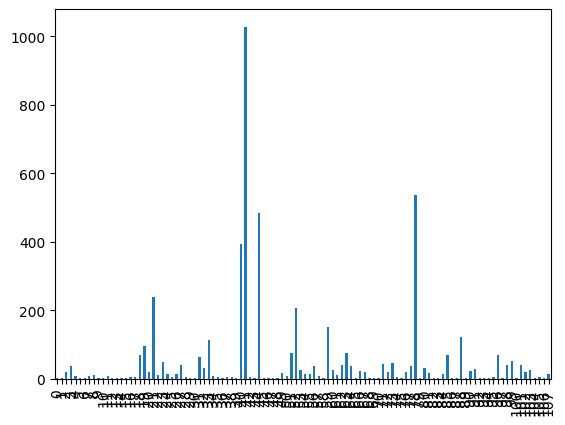

In [7]:
# create histograms for length of total script
def plotLengethOfTotalScript(df):
    # grouped.plot(kind='bar')
    pd.Series(grouped["Sentence"]).plot(kind='bar')

plotLengethOfTotalScript(m.movies_df)

In [8]:
# Combine sentences for each character
combined_sentences = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

#Add columns for Vocabulary, vocabulary size, unique words (mentioned one time) ans most frequent words
combined_sentences['vocabulary'] = None
combined_sentences['vocabulary_size'] = None
combined_sentences['words_mentioned_once'] = None
combined_sentences['most_frequent_words'] = None

In [9]:
def PreProcessToRemoveDelimetersAndNumbers(text):

    # Define a regular expression pattern to match delimiters and numbers
    pattern = r'[.,;:!?0-9]+'
    
    # Use the re.sub function to remove delimiters and numbers
    preprocessed_text = re.sub(pattern, ' ', text)
    
    # Remove extra whitespaces
    preprocessed_text = ' '.join(preprocessed_text.split())
    
    return preprocessed_text

In [29]:
def generate_Vocabulary_UniqueWords_WordsFrequency(combined_sentences) :

    for index, row in combined_sentences.iterrows():
        character = row['Character']
        sentences = row['Sentence']

        sentences = PreProcessToRemoveDelimetersAndNumbers(sentences)
        # Tokenize the text into words
        words = nltk.word_tokenize(sentences)    
        
        # Create a vocabulary (set of unique words)
        vocabulary = set(words)
    
        # Convert the set back to a sorted list if needed
        vocabulary_list = sorted(list(vocabulary))
    
        combined_sentences.at[index, 'vocabulary']=vocabulary_list
    
        # Calculate vocabulary size (total unique words)
        vocabulary_size = len(set(vocabulary))
    
        # row['vocabulary_size']==vocabulary_size
        combined_sentences.at[index, 'vocabulary_size'] = vocabulary_size
    
        # Create a word frequency dictionary
        word_frequency = Counter(words)
    
        # Find words mentioned only once
        words_mentioned_once = [word for word, freq in word_frequency.items() if freq == 1]
        combined_sentences.at[index, 'words_mentioned_once']=words_mentioned_once
    
        # Find the thirty most frequent words
        most_frequent_words_list = word_frequency.most_common(30)
        # Extract the words from the list of tuples
        most_frequent_words = [word for word, count in most_frequent_words_list]
        combined_sentences.at[index, 'most_frequent_words']=most_frequent_words


In [30]:
generate_Vocabulary_UniqueWords_WordsFrequency(combined_sentences)

In [31]:
#Display the result
print(combined_sentences['vocabulary'])

0                                        [AHHHHHHH, YAY]
1            ['s, Sorcerer, Stone, We, about, know, the]
2      ['s, But, Chamber, Go, Goodbye, Hagrid, I, Is,...
3      [', 'd, 's, 'yes, A, Actually, And, Bad, Brutu...
4      [For, Harry, He, How, Marge, Masons, Not, Noth...
                             ...                        
103    ['ll, 's, A, All, Arrrhhhhhh, Bravery, But, Do...
104                                      [Harry, Potter]
105    ['ll, 'm, Come, Crockford, Doris, I, Mr, Not, ...
106                 [Anything, dears, off, the, trolley]
107    ['re, 've, All, Flint, Gryffindor, Harry, Huff...
Name: vocabulary, Length: 108, dtype: object


In [32]:
print(combined_sentences['vocabulary_size'])

0        2
1        7
2       92
3      144
4       34
      ... 
103    112
104      2
105     33
106      5
107     75
Name: vocabulary_size, Length: 108, dtype: object


In [33]:
print(combined_sentences['words_mentioned_once'])

0                                        [AHHHHHHH, YAY]
1            [We, know, about, the, Sorcerer, 's, Stone]
2      [Who, Is, that, you, Yes, has, sent, men, holl...
3      [still, here, 'yes, in, ungrateful, way, Damn,...
4      [Not, now, Pupkins, For, when, Masons, arrive,...
                             ...                        
103    [Use, boy, He, Let, speak, strength, this, Pot...
104                                      [Harry, Potter]
105    [Doris, Crockford, Mr, Potter, ca, n't, believ...
106                 [Anything, off, the, trolley, dears]
107    [spent, summer, devising, whole, program, gon,...
Name: words_mentioned_once, Length: 108, dtype: object


In [34]:
print(combined_sentences['most_frequent_words'])

0                                        [AHHHHHHH, YAY]
1            [We, know, about, the, Sorcerer, 's, Stone]
2      [Hagrid, the, of, I, a, in, not, it, never, wa...
3      [a, you, with, 's, the, n't, You, Do, to, boy,...
4      [the, Harry, to, Oh, He, Not, now, Pupkins, Fo...
                             ...                        
103    [me, can, to, I, it, is, and, the, him, Harry,...
104                                      [Harry, Potter]
105    [you, I, Doris, Crockford, Mr, Potter, ca, n't...
106                 [Anything, off, the, trolley, dears]
107    [I, the, We, a, new, 're, n't, to, Quidditch, ...
Name: most_frequent_words, Length: 108, dtype: object


In [50]:
combined_sentences.sort_values('vocabulary_size', ascending=False).head(50)

,Character,Sentence,vocabulary,vocabulary_size,words_mentioned_once,most_frequent_words
41,Harry,"Yes, Aunt Petunia. Yes, Uncle Vernon. He's asl...","[', 'd, 'll, 'm, 're, 's, 've, /, A, Admirers,...",1161,"[Aunt, Petunia, watching, press, ugly, often, ...","[I, 's, you, the, to, it, n't, me, a, that, of..."
78,Ron,Excuse me. Do you mind? Everywhere else is ful...,"[', '', 'd, 'll, 'm, 're, 's, 've, A, Aaa, Act...",872,"[Excuse, mind, Everywhere, full, scar, thanks,...","['s, you, I, the, it, a, to, Harry, n't, do, i..."
44,Hermione,Has anyone seen a toad? A boy named Neville's ...,"[', 'd, 'll, 'm, 're, 's, 've, A, According, A...",861,"[Has, toad, named, doing, magic, spell, tried,...","['s, you, the, to, I, n't, Harry, a, it, It, i..."
21,Dumbledore,"I should've known that you would be here, Prof...","['d, 'll, 'm, 're, 's, 've, -year-old, A, Afte...",808,"[here, bad, bringing, problems, Albus, leaving...","[the, to, I, you, of, a, that, is, in, it, and..."
40,Hagrid,"Professor Dumbledore, sir. Professor McGonagal...","[', 'bout, 'd, 'll, 'm, 're, 'round, 's, 've, ...",800,"[McGonagall, Little, tyke, fell, asleep, flyin...","[you, I, to, 's, a, n't, Harry, the, that, and..."
52,Lupin,"Here, eat this. It'll help. It's all right. It...","['d, 'll, 'm, 're, 's, 've, A, Absolutely, Aft...",566,"[help, chocolate, guards, Azkaban, gone, searc...","[you, I, the, to, a, it, your, of, 's, Harry, ..."
59,Mcgonagall,"Good evening, Professor Dumbledore. Are the ru...","['d, 'll, 'm, 're, 's, 've, A, Ahh, Albus, All...",524,"[Are, rumors, Do, wise, Hagrid, important, 've...","[the, you, to, I, of, be, will, your, a, and, ..."
88,Snape,There will be no foolish wand-waving or silly ...,"['', 'd, 'll, 're, 's, 've, A, After, And, Ang...",493,"[foolish, wand-waving, incantations, class, ex...","[the, you, of, to, I, a, Potter, your, it, be,..."
33,Gilderoy Lockhart,Let me introduce you to your new Defense Again...,"['d, 'll, 'm, 're, 's, 've, Aemm…, Against, Ag...",419,"[new, Against, Arts, Teacher, Me, Gilderoy, Lo...","[to, I, you, the, of, n't, me, do, that, have,..."
96,Tom Riddle,"Professor Dumbledore. Yes, professor. I suppos...","[', 'd, 'll, 'm, 's, -year-old, A, About, And,...",327,"[Professor, suppose, rumors, true, About, well...","[I, to, the, n't, you, a, of, it, was, 's, be,..."


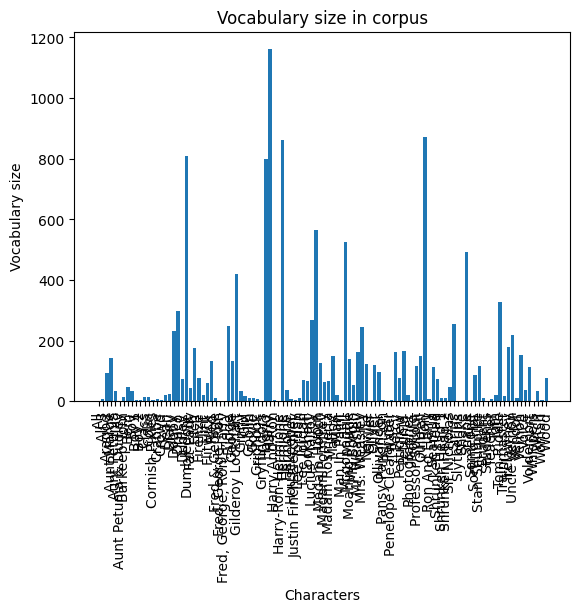

<Figure size 3000x2300 with 0 Axes>

In [71]:
# create histograms for vocabulary size of characters
def plotVocabularySizeOfCharacters(df):
    # pd.Series(df['vocabulary_size']).plot(kind='bar')
    plt.bar(df['Character'].tolist(), df['vocabulary_size'].tolist())
    plt.title("Vocabulary size in corpus")
    plt.ylabel("Vocabulary size")
    plt.xlabel("Characters")
    plt.xticks(rotation='vertical')
    plt.figure(figsize=(30, 23))
    plt.show()

plotVocabularySizeOfCharacters(combined_sentences)

In [56]:
combined_sentences_50_most_vocabulary=combined_sentences.sort_values('vocabulary_size', ascending=False).reset_index().head(50)

In [57]:
combined_sentences_50_most_vocabulary

,index,Character,Sentence,vocabulary,vocabulary_size,words_mentioned_once,most_frequent_words
0,41,Harry,"Yes, Aunt Petunia. Yes, Uncle Vernon. He's asl...","[', 'd, 'll, 'm, 're, 's, 've, /, A, Admirers,...",1161,"[Aunt, Petunia, watching, press, ugly, often, ...","[I, 's, you, the, to, it, n't, me, a, that, of..."
1,78,Ron,Excuse me. Do you mind? Everywhere else is ful...,"[', '', 'd, 'll, 'm, 're, 's, 've, A, Aaa, Act...",872,"[Excuse, mind, Everywhere, full, scar, thanks,...","['s, you, I, the, it, a, to, Harry, n't, do, i..."
2,44,Hermione,Has anyone seen a toad? A boy named Neville's ...,"[', 'd, 'll, 'm, 're, 's, 've, A, According, A...",861,"[Has, toad, named, doing, magic, spell, tried,...","['s, you, the, to, I, n't, Harry, a, it, It, i..."
3,21,Dumbledore,"I should've known that you would be here, Prof...","['d, 'll, 'm, 're, 's, 've, -year-old, A, Afte...",808,"[here, bad, bringing, problems, Albus, leaving...","[the, to, I, you, of, a, that, is, in, it, and..."
4,40,Hagrid,"Professor Dumbledore, sir. Professor McGonagal...","[', 'bout, 'd, 'll, 'm, 're, 'round, 's, 've, ...",800,"[McGonagall, Little, tyke, fell, asleep, flyin...","[you, I, to, 's, a, n't, Harry, the, that, and..."
5,52,Lupin,"Here, eat this. It'll help. It's all right. It...","['d, 'll, 'm, 're, 's, 've, A, Absolutely, Aft...",566,"[help, chocolate, guards, Azkaban, gone, searc...","[you, I, the, to, a, it, your, of, 's, Harry, ..."
6,59,Mcgonagall,"Good evening, Professor Dumbledore. Are the ru...","['d, 'll, 'm, 're, 's, 've, A, Ahh, Albus, All...",524,"[Are, rumors, Do, wise, Hagrid, important, 've...","[the, you, to, I, of, be, will, your, a, and, ..."
7,88,Snape,There will be no foolish wand-waving or silly ...,"['', 'd, 'll, 're, 's, 've, A, After, And, Ang...",493,"[foolish, wand-waving, incantations, class, ex...","[the, you, of, to, I, a, Potter, your, it, be,..."
8,33,Gilderoy Lockhart,Let me introduce you to your new Defense Again...,"['d, 'll, 'm, 're, 's, 've, Aemm…, Against, Ag...",419,"[new, Against, Arts, Teacher, Me, Gilderoy, Lo...","[to, I, you, the, of, n't, me, do, that, have,..."
9,96,Tom Riddle,"Professor Dumbledore. Yes, professor. I suppos...","[', 'd, 'll, 'm, 's, -year-old, A, About, And,...",327,"[Professor, suppose, rumors, true, About, well...","[I, to, the, n't, you, a, of, it, was, 's, be,..."


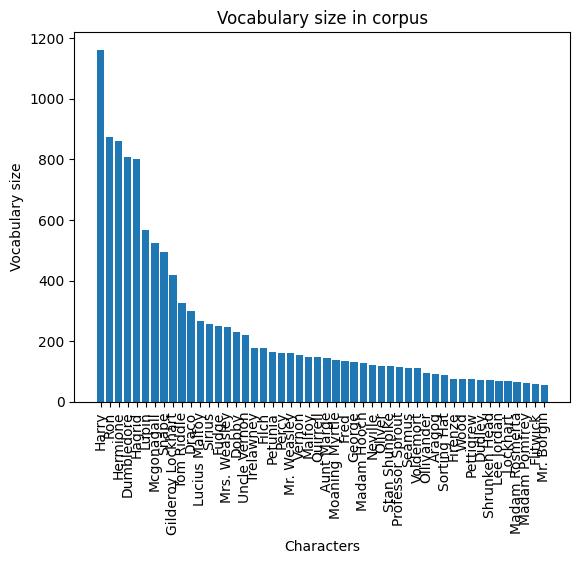

<Figure size 3000x2300 with 0 Axes>

In [72]:
plotVocabularySizeOfCharacters(combined_sentences_50_most_vocabulary)

In [74]:
combined_sentences_50_most_vocabulary['most_frequent_words']

0     [I, 's, you, the, to, it, n't, me, a, that, of...
1     ['s, you, I, the, it, a, to, Harry, n't, do, i...
2     ['s, you, the, to, I, n't, Harry, a, it, It, i...
3     [the, to, I, you, of, a, that, is, in, it, and...
4     [you, I, to, 's, a, n't, Harry, the, that, and...
5     [you, I, the, to, a, it, your, of, 's, Harry, ...
6     [the, you, to, I, of, be, will, your, a, and, ...
7     [the, you, of, to, I, a, Potter, your, it, be,...
8     [to, I, you, the, of, n't, me, do, that, have,...
9     [I, to, the, n't, you, a, of, it, was, 's, be,...
10    [the, you, I, 's, You, to, n't, this, that, it...
11    [I, you, the, of, You, to, be, do, it, a, at, ...
12    [you, I, to, 's, the, a, n't, and, your, Remus...
13    [the, to, 's, of, I, Hagrid, that, have, him, ...
14    [you, 's, dear, Harry, on, to, it, ’, I, of, T...
15    [Dobby, to, Harry, Potter, sir, is, ’, ho, Bad...
16    [’, you, the, I, s, You, that, it, of, and, to...
17    [the, you, of, shall, I, your, be, dear, a

In [75]:
def SimilarityMatrixByCommonWords(characters, word_lists):
    text = [" ".join(word_list) for word_list in word_lists]
    # Initialize a CountVectorizer to convert text to a bag of words
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    
    # Create a character-to-character Jaccard similarity matrix
    character_names = characters.tolist()
    similarity_matrix = []

    #Similarity by common words
    for i in range(len(character_names)):
        row = []
        for j in range(len(character_names)):
            if i == j:
                similarity = 1.0  # Similarity with oneself is 1.0
            else:
                set1 = set(X[i].indices)
                set2 = set(X[j].indices)
                intersection = len(set1.intersection(set2))
                union = len(set1) + len(set2) - intersection
                similarity = intersection / union
            row.append(similarity)
        similarity_matrix.append(row)

    #Matrix
    similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)    

    return similarity_df

In [38]:
def CharacterToCharacterMatrixPlot(characters, matrix):
    character_names = characters.tolist()
    # Plot the character-to-character matrix
    plt.figure(figsize=(25, 25))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(character_names)), character_names, rotation=45)
    plt.yticks(range(len(character_names)), character_names)
    plt.title('Character-to-Character Matrix')
    plt.show()

In [80]:
def mostCommonPairs(characters, matrix, number) :
    character_names = characters.tolist()
    most_common_pairs = []
    for character1 in character_names:
        for character2 in character_names:
            if character1 != character2:
                count = matrix.at[character1, character2]
                most_common_pairs.append((character1, character2, count))
    
    # Sort the list of pairs by count in descending order
    most_common_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Display the most common pairs
    print("Most Common Pairs:")    
    for x in range(number):
        print(f"{most_common_pairs[x][0]} and {most_common_pairs[x][1]}: {most_common_pairs[x][2]} Similarity")

In [81]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Vocabulary
similarity_df = SimilarityMatrixByCommonWords(combined_sentences['Character'], combined_sentences['vocabulary'])

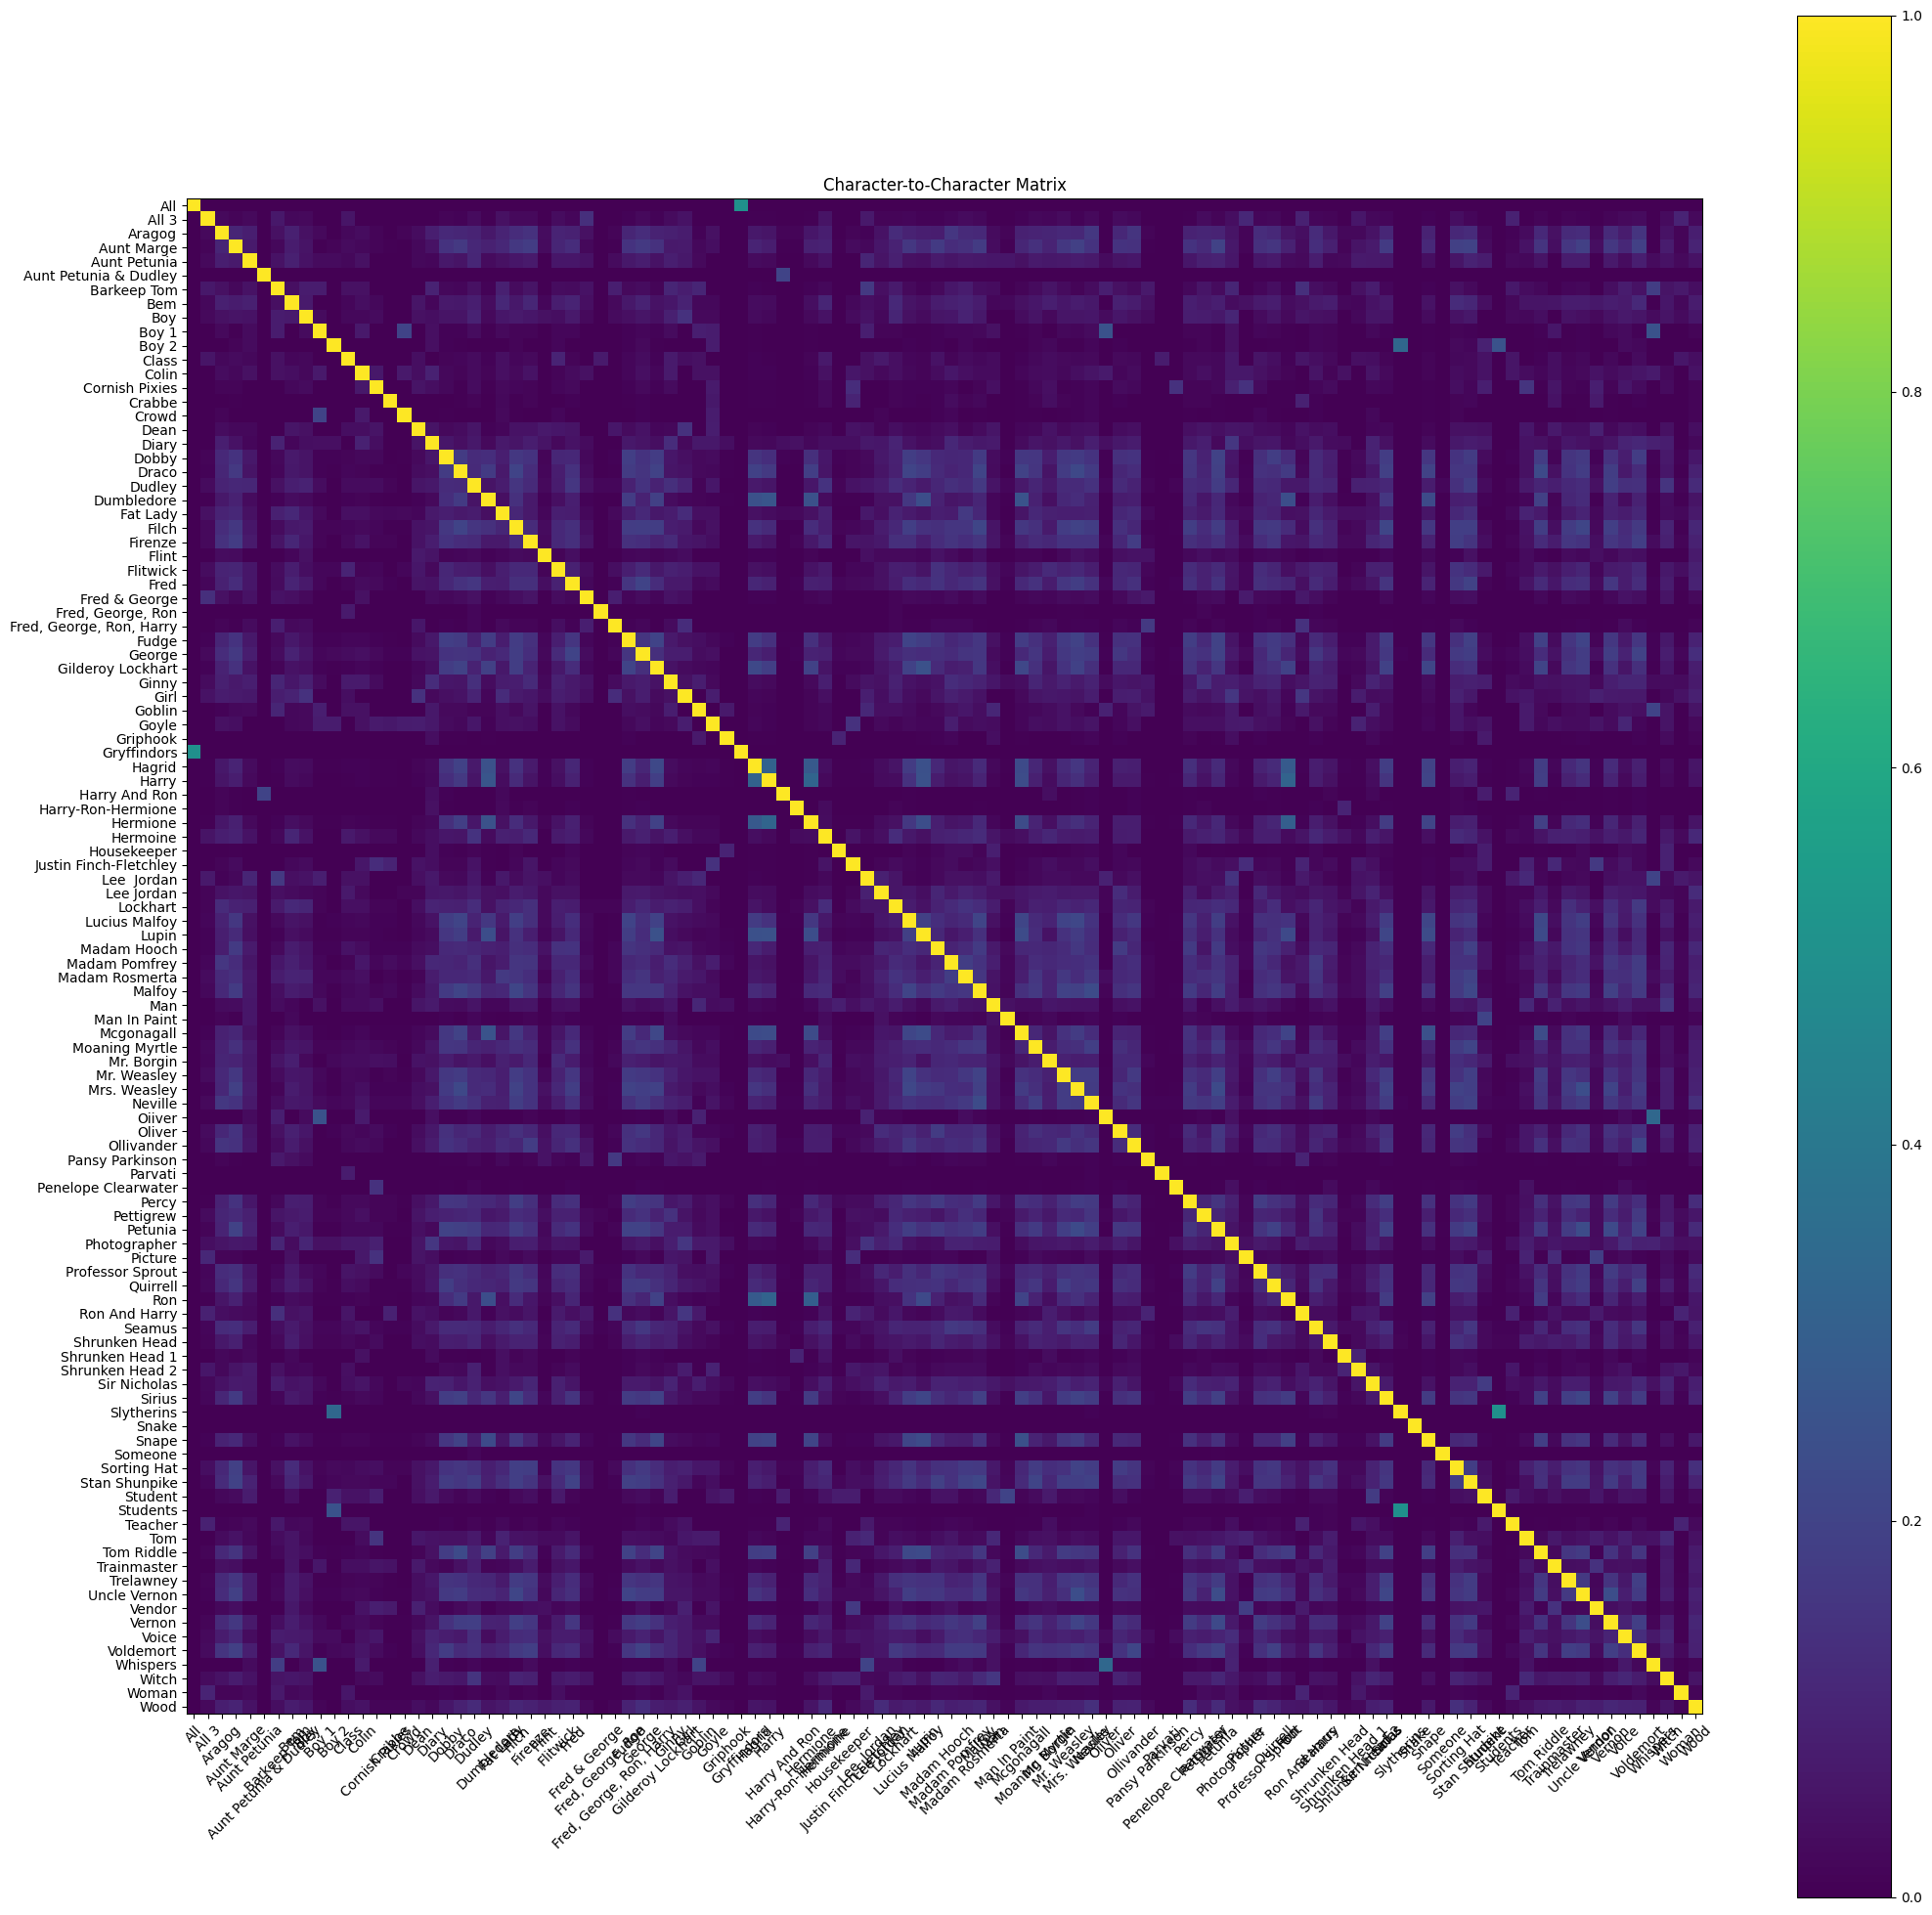

In [82]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences['Character'], similarity_df)

In [83]:
#Most 30 common paris
mostCommonPairs(combined_sentences['Character'], similarity_df, 30)

Most Common Pairs:
All and Gryffindors: 0.5 Similarity
Gryffindors and All: 0.5 Similarity
Slytherins and Students: 0.5 Similarity
Students and Slytherins: 0.5 Similarity
Boy 2 and Slytherins: 0.3333333333333333 Similarity
Oiiver and Whispers: 0.3333333333333333 Similarity
Slytherins and Boy 2: 0.3333333333333333 Similarity
Whispers and Oiiver: 0.3333333333333333 Similarity
Harry and Hermione: 0.32216298552932215 Similarity
Hermione and Harry: 0.32216298552932215 Similarity
Harry and Ron: 0.31880733944954126 Similarity
Ron and Harry: 0.31880733944954126 Similarity
Hagrid and Harry: 0.3153724247226624 Similarity
Harry and Hagrid: 0.3153724247226624 Similarity
Hermione and Ron: 0.300513698630137 Similarity
Ron and Hermione: 0.300513698630137 Similarity
Hagrid and Ron: 0.28495102404274264 Similarity
Ron and Hagrid: 0.28495102404274264 Similarity
Hagrid and Hermione: 0.27768014059753954 Similarity
Hermione and Hagrid: 0.27768014059753954 Similarity
Dumbledore and Harry: 0.262012012012012 S

In [84]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Unique words of each character
similarity_unique_words_df = SimilarityMatrixByCommonWords(combined_sentences['Character'], combined_sentences['words_mentioned_once'])

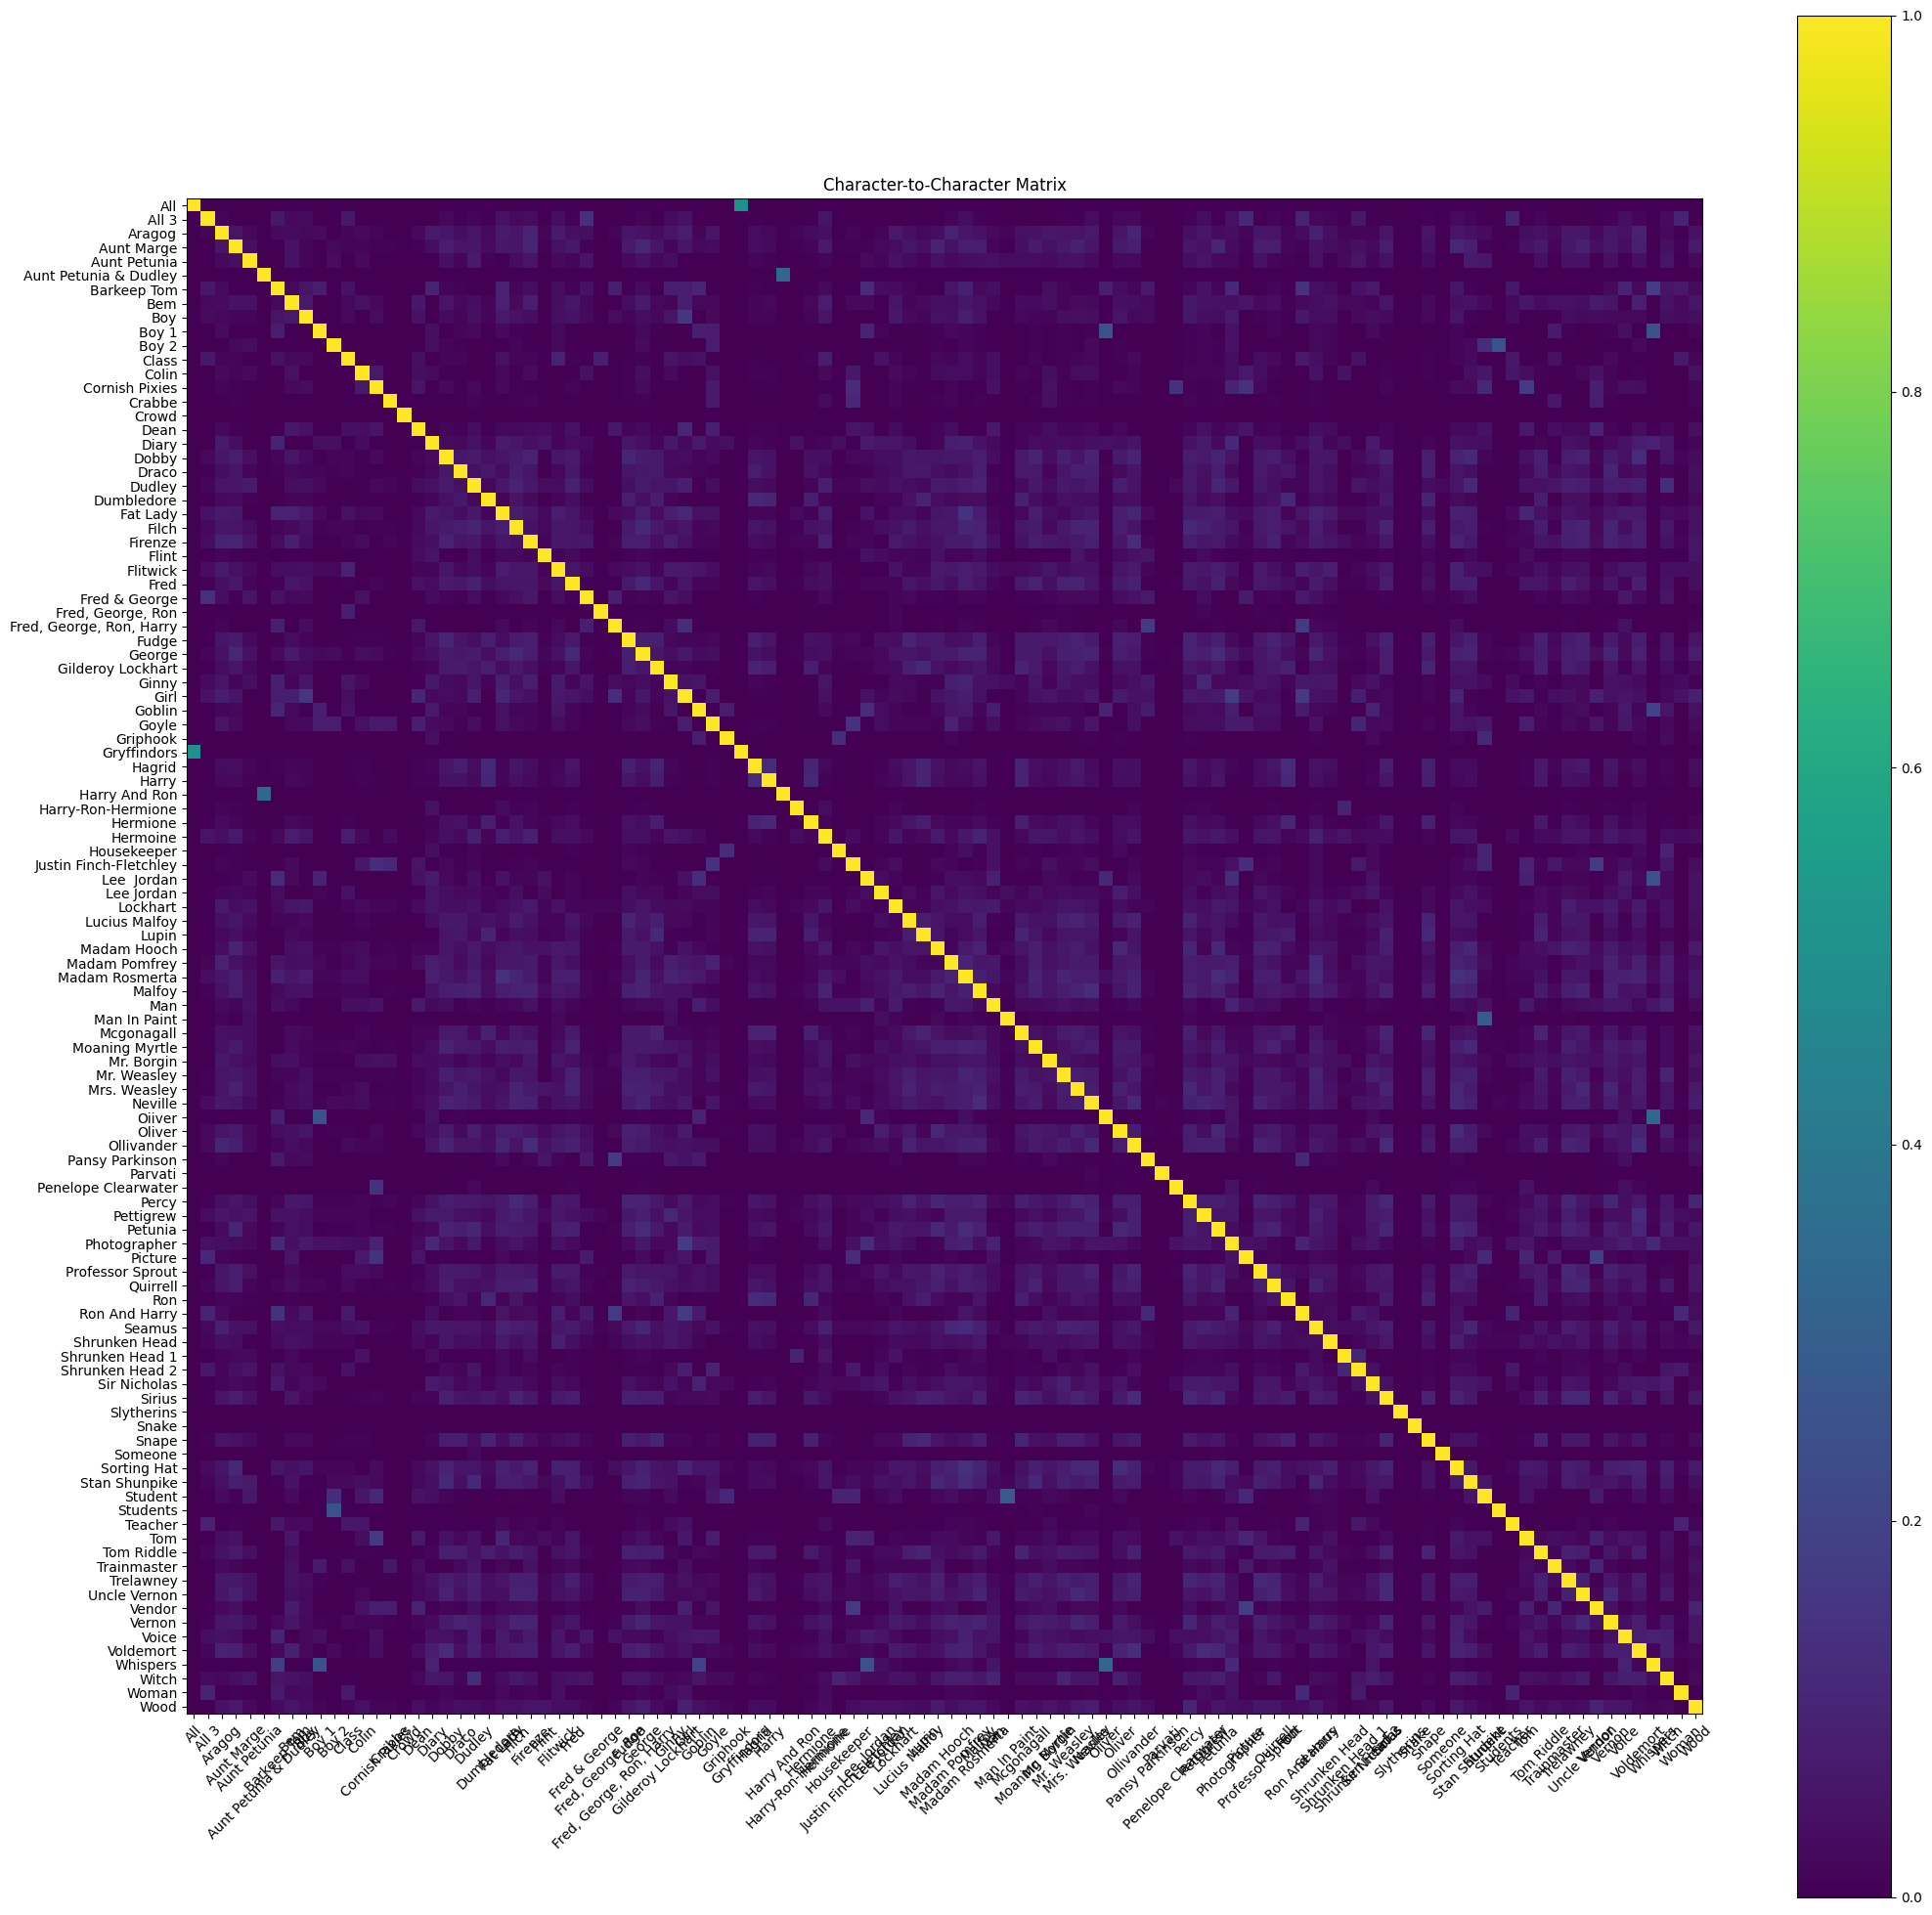

In [85]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences['Character'], similarity_unique_words_df)

In [86]:
#Most common pairs
mostCommonPairs(combined_sentences['Character'], similarity_unique_words_df, 30)

Most Common Pairs:
All and Gryffindors: 0.5 Similarity
Gryffindors and All: 0.5 Similarity
Aunt Petunia & Dudley and Harry And Ron: 0.3333333333333333 Similarity
Harry And Ron and Aunt Petunia & Dudley: 0.3333333333333333 Similarity
Oiiver and Whispers: 0.3333333333333333 Similarity
Whispers and Oiiver: 0.3333333333333333 Similarity
Man In Paint and Student: 0.2857142857142857 Similarity
Student and Man In Paint: 0.2857142857142857 Similarity
Boy 1 and Oiiver: 0.25 Similarity
Boy 1 and Whispers: 0.25 Similarity
Boy 2 and Students: 0.25 Similarity
Lee  Jordan and Whispers: 0.25 Similarity
Oiiver and Boy 1: 0.25 Similarity
Students and Boy 2: 0.25 Similarity
Whispers and Boy 1: 0.25 Similarity
Whispers and Lee  Jordan: 0.25 Similarity
Goblin and Whispers: 0.2 Similarity
Whispers and Goblin: 0.2 Similarity
Barkeep Tom and Whispers: 0.18181818181818182 Similarity
Picture and Vendor: 0.18181818181818182 Similarity
Vendor and Picture: 0.18181818181818182 Similarity
Whispers and Barkeep Tom: 

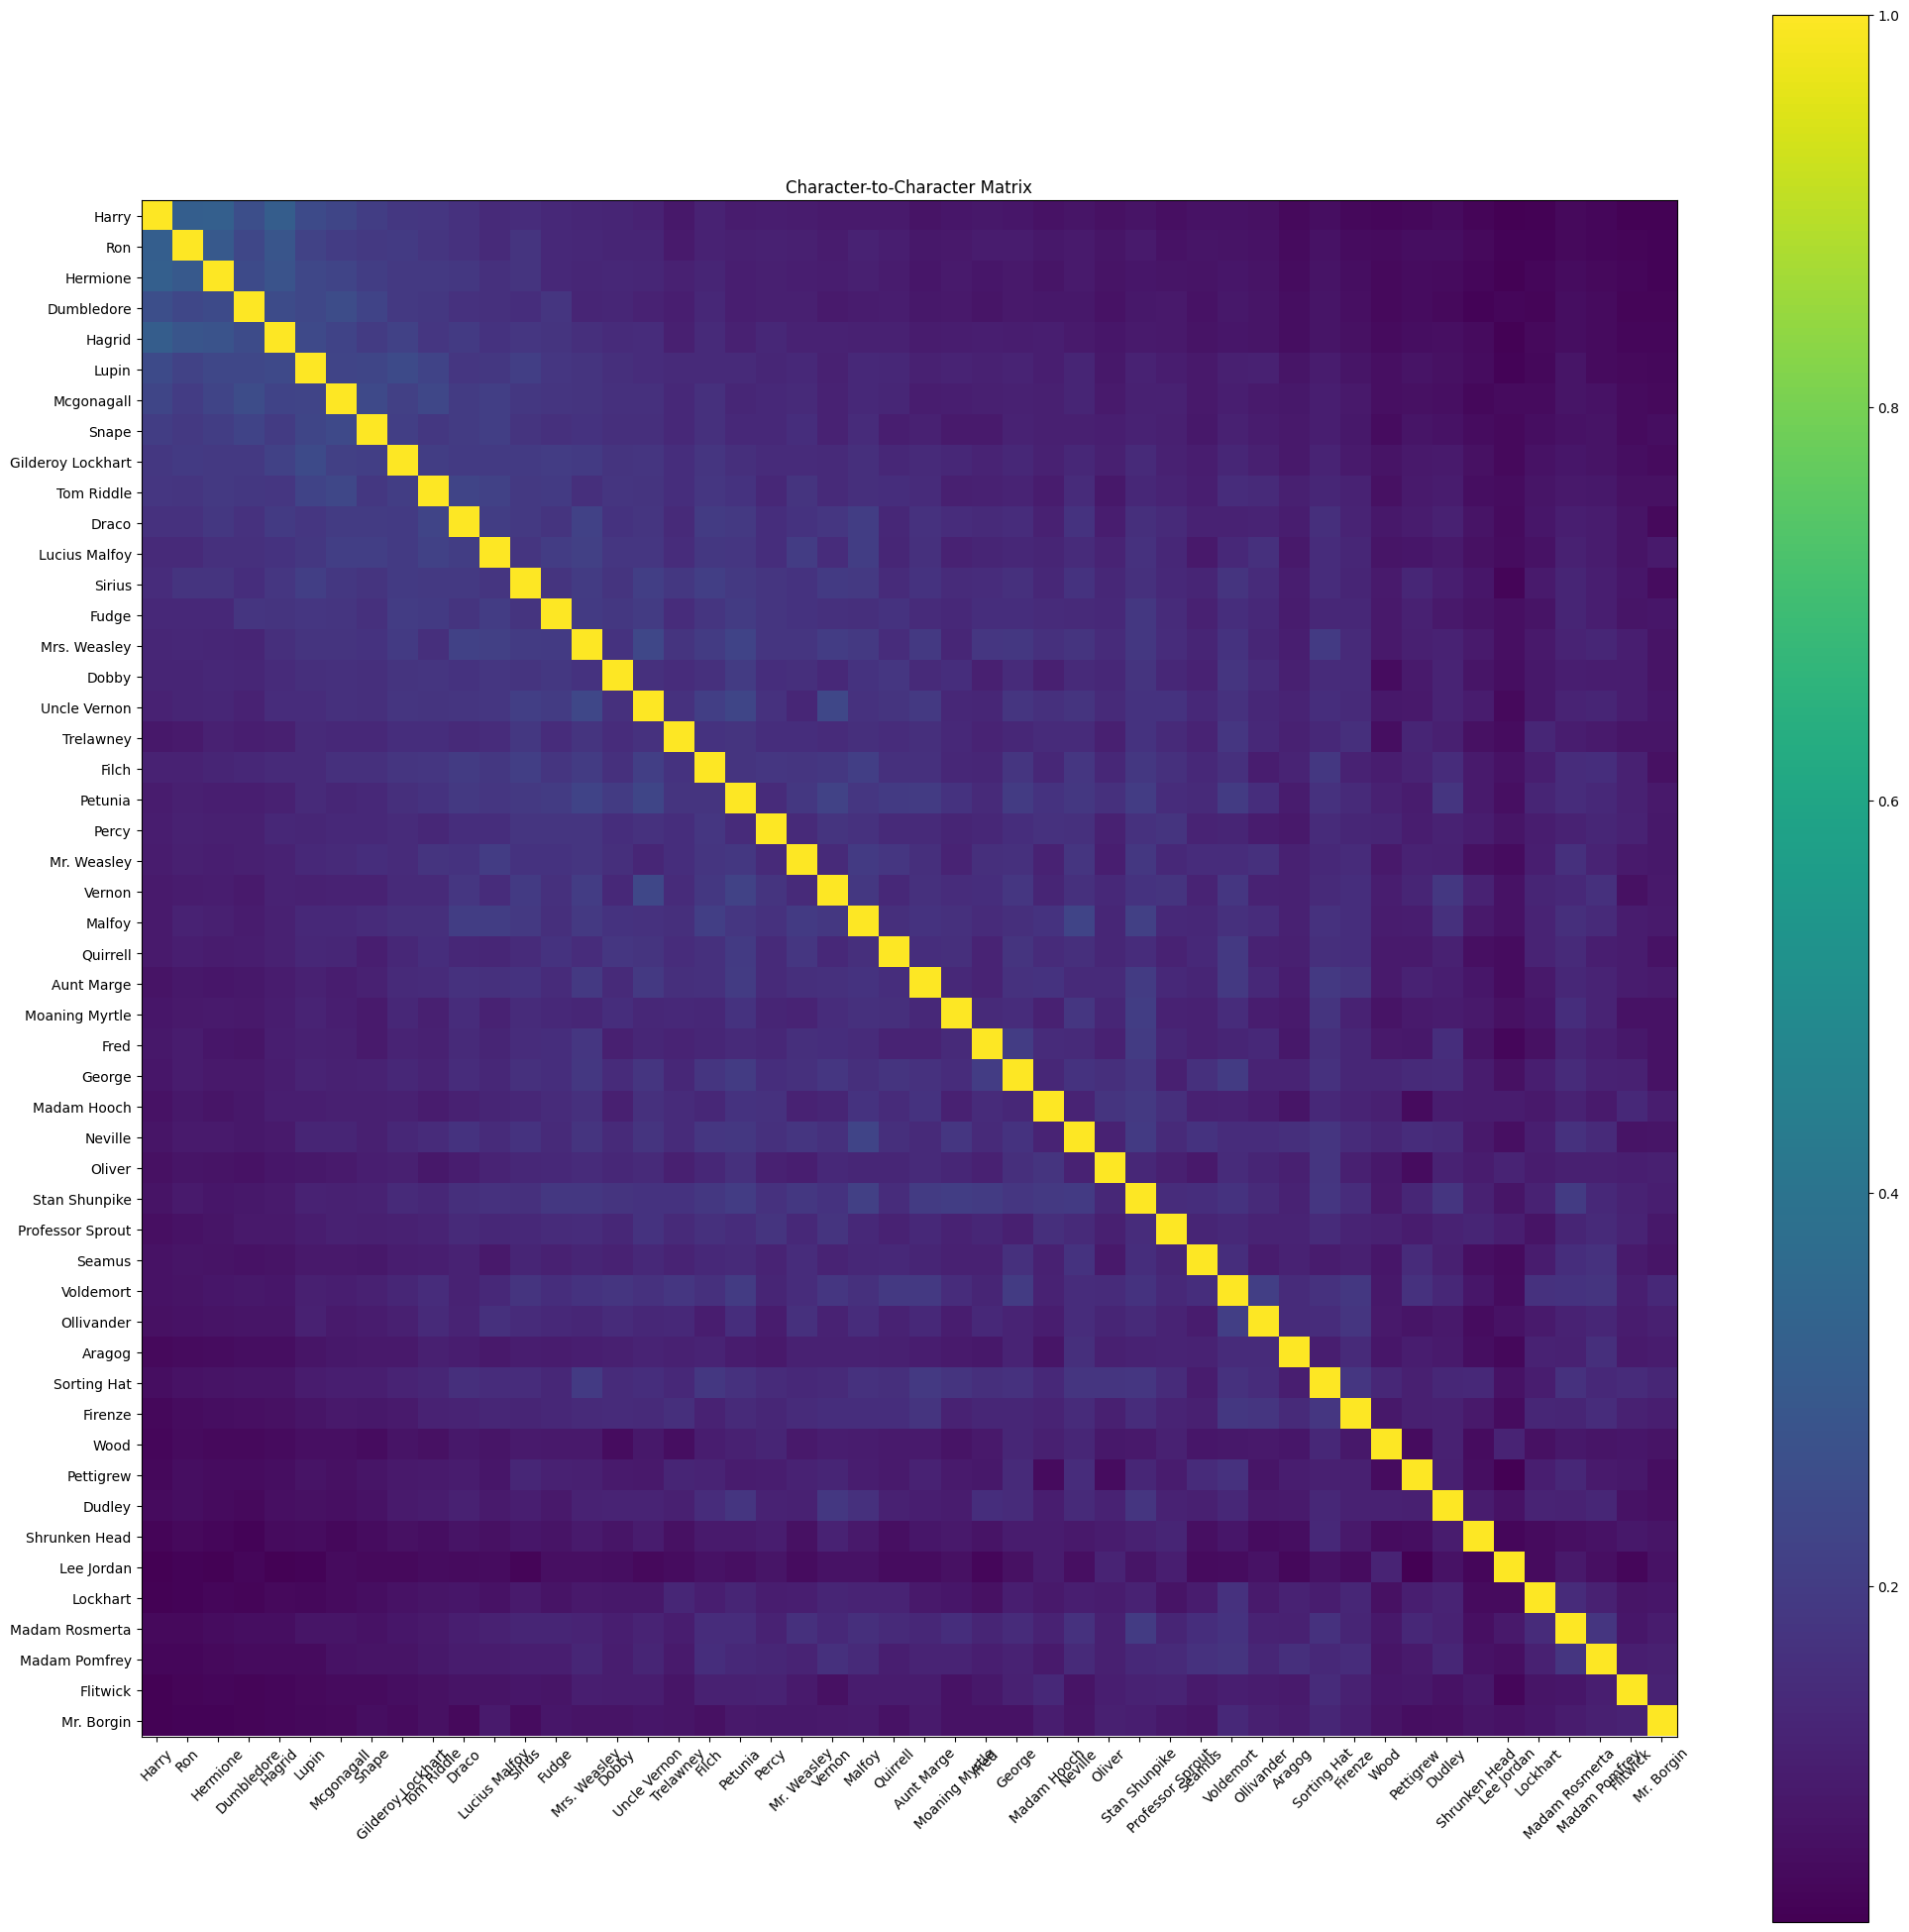

In [87]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Vocabulary
similarity_df_50_most_vocabulary = SimilarityMatrixByCommonWords(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['vocabulary'])

#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], similarity_df_50_most_vocabulary)

In [88]:
#Most 30 common paris
mostCommonPairs(combined_sentences_50_most_vocabulary['Character'], similarity_df_50_most_vocabulary, 30)

Most Common Pairs:
Harry and Hermione: 0.32216298552932215 Similarity
Hermione and Harry: 0.32216298552932215 Similarity
Harry and Ron: 0.31880733944954126 Similarity
Ron and Harry: 0.31880733944954126 Similarity
Harry and Hagrid: 0.3153724247226624 Similarity
Hagrid and Harry: 0.3153724247226624 Similarity
Ron and Hermione: 0.300513698630137 Similarity
Hermione and Ron: 0.300513698630137 Similarity
Ron and Hagrid: 0.28495102404274264 Similarity
Hagrid and Ron: 0.28495102404274264 Similarity
Hermione and Hagrid: 0.27768014059753954 Similarity
Hagrid and Hermione: 0.27768014059753954 Similarity
Harry and Dumbledore: 0.262012012012012 Similarity
Dumbledore and Harry: 0.262012012012012 Similarity
Dumbledore and Mcgonagall: 0.2552966101694915 Similarity
Mcgonagall and Dumbledore: 0.2552966101694915 Similarity
Dumbledore and Hagrid: 0.24910714285714286 Similarity
Hagrid and Dumbledore: 0.24910714285714286 Similarity
Harry and Lupin: 0.24808836023789294 Similarity
Lupin and Harry: 0.24808836

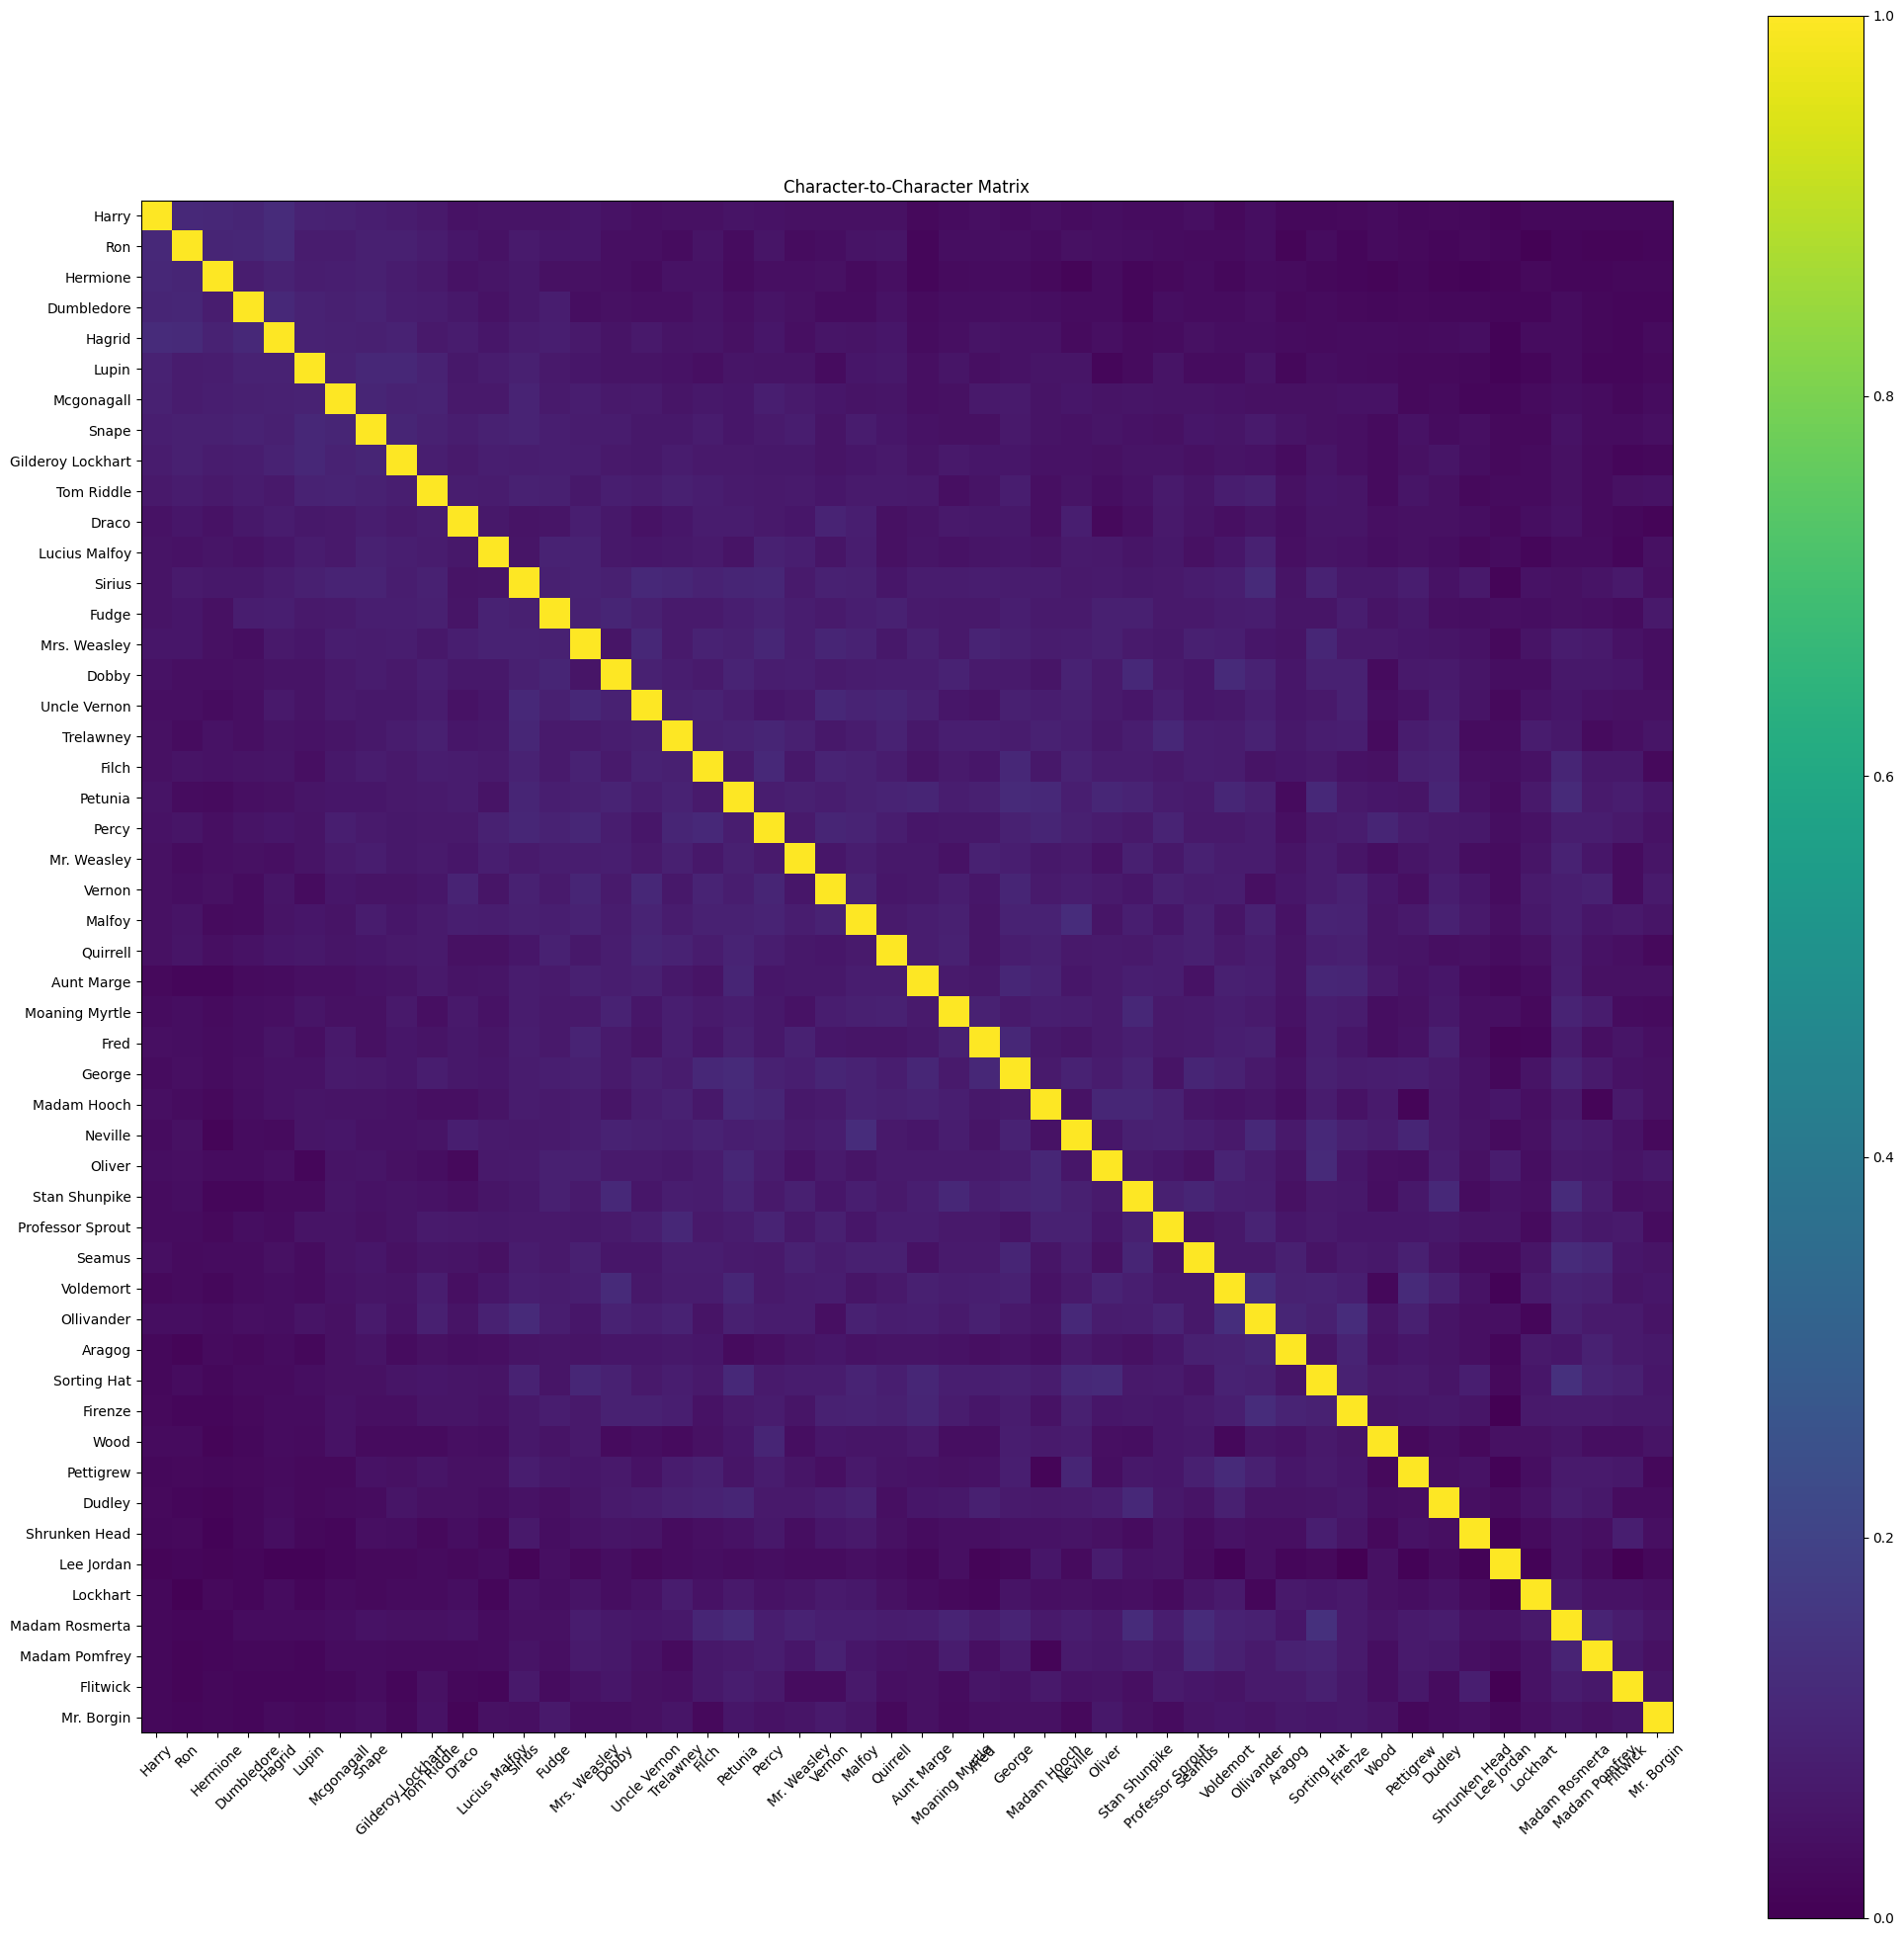

In [89]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Unique words of each character
similarity_unique_words_df_50_most_vocabulary = SimilarityMatrixByCommonWords(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['words_mentioned_once'])

#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], similarity_unique_words_df_50_most_vocabulary)

In [90]:
#Plot the matrix
mostCommonPairs(combined_sentences_50_most_vocabulary['Character'], similarity_unique_words_df_50_most_vocabulary, 30)

Most Common Pairs:
Sorting Hat and Madam Rosmerta: 0.13861386138613863 Similarity
Madam Rosmerta and Sorting Hat: 0.13861386138613863 Similarity
Voldemort and Ollivander: 0.1297709923664122 Similarity
Ollivander and Voldemort: 0.1297709923664122 Similarity
Malfoy and Neville: 0.125 Similarity
Neville and Malfoy: 0.125 Similarity
Ollivander and Firenze: 0.125 Similarity
Firenze and Ollivander: 0.125 Similarity
Seamus and Madam Rosmerta: 0.12403100775193798 Similarity
Madam Rosmerta and Seamus: 0.12403100775193798 Similarity
Stan Shunpike and Madam Rosmerta: 0.12280701754385964 Similarity
Madam Rosmerta and Stan Shunpike: 0.12280701754385964 Similarity
Harry and Hagrid: 0.12247071352502663 Similarity
Hagrid and Harry: 0.12247071352502663 Similarity
Voldemort and Pettigrew: 0.1206896551724138 Similarity
Pettigrew and Voldemort: 0.1206896551724138 Similarity
Dobby and Voldemort: 0.12060301507537688 Similarity
Voldemort and Dobby: 0.12060301507537688 Similarity
Oliver and Sorting Hat: 0.119